In [63]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
from moviepy.editor import VideoFileClip
global attempted
global left_line,right_line,prev_pts
%matplotlib inline

In [239]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # No. of values
        self.nvalues = 5
        # Current iteration
        self.current = 0 
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
global left_line,right_line
left_line = Line()
right_line = Line()

In [2]:
images = glob.glob("camera_cal/calibration*.jpg")
objpoints = []
imgpoints = []

objp = np.zeros((9*6,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

for imgname in images:
    img = mpimg.imread(imgname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
#     plt.imshow(gray,cmap='gray')

    ret, corners = cv2.findChessboardCorners(gray,(9,6),None)
    if ret==True:
        objpoints.append(objp)
        imgpoints.append(corners)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


In [5]:
def color_n_gradient(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    image = cv2.undistort(img,mtx, dist, None, mtx)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]
    h_channel = hls[:,:,0]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = sx_thresh[0]
    thresh_max = sx_thresh[1]
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = s_thresh[0]
    s_thresh_max = s_thresh[1]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(s_binary), sxbinary, s_binary))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary

In [294]:
def process_image(img):
    global prev_pts
    image = np.copy(img)
    imshape = image.shape
    offset = int(imshape[0]*0.1)
    hsv_bit = color_n_gradient(image)
    
    edge = np.zeros_like(hsv_bit)
    mask_bit_value = 255
    mask = np.array([[(0,imshape[0]),(imshape[1]*0.53, imshape[0]/1.8), (imshape[1]*0.47, imshape[0]/1.8), (imshape[1],imshape[0])]], dtype=np.int32)
    cv2.fillPoly(edge,mask,mask_bit_value)
    
    hsv_bit = cv2.bitwise_and(hsv_bit,edge)
#     plt.imshow(hsv_bit,cmap="gray")
    
    row = 2
    theta = np.pi/90
    threshold = 55
    min_line_len = 40
    max_line_gap = 15

    lines = cv2.HoughLinesP(hsv_bit,row,theta,threshold,min_line_len,max_line_gap)
#     print(lines.shape)
    if(lines==None):
        return

    xa = []
    xb = []
    xc = []
    xd = []
    ya = int(image.shape[0])
    yb = int(image.shape[0]/1.6)

    for line in lines:
        for x1,y1,x2,y2 in line:
#             cv2.line(image,(x1,y1),(x2,y2),(255,0,0),2)
            m = (y2-y1)/(x2-x1)
            c = y2-(m*x2)
            if(-0.9<m<-0.5):
                xa.append(int((ya-c)/m))
                xb.append(int((yb-c)/m))

            elif(0.9>m>0.55):
                xc.append(int((ya-c)/m))
                xd.append(int((yb-c)/m))
    x1 = int(np.mean(xa))
    x2 = int(np.mean(xb))
    try:
        x3 = int(np.mean(xc))
    except:
        x3 = prev_pts[2,0]-offset
    try:
        x4 = int(np.mean(xd))
    except:
        x4 = prev_pts[3,0]-offset
    cv2.line(image,(x1,ya),(x2,yb),(0,255,0),8)
    cv2.line(image,(x3,ya),(x4,yb),(0,255,0),8)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image,'Left Slope = '+str((yb-ya)/(x2-x1)),(100,50), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(image,'Right Curvature = '+str((yb-ya)/(x4-x3)),(100,80), font, 1,(255,255,255),2,cv2.LINE_AA)
    
    ya = int(image.shape[0]*0.9)
    prev_pts = np.int32([[x1-offset,ya],[x2-offset,yb],[x3+offset,ya],[x4+offset,yb]])
    return prev_pts
#     return image

In [214]:
def get_warped(cng, src):
    dst = np.float32([[-200,0],[1430,0],[0,720],[1280,720]])
    idx=[1,3,0,2]
    
    M = cv2.getPerspectiveTransform(np.float32(src[idx]),dst)
    Minv = cv2.getPerspectiveTransform(dst, np.float32(src[idx]))

    binary_warped = cv2.warpPerspective(cng,M,(1280,720),flags=cv2.INTER_LINEAR)
    
    return binary_warped,Minv

In [8]:
def line_detect(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
#     print(leftx.shape)
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
#     print(left_fit.shape)
    return left_fit,right_fit
#     return show_finished(left_fit,right_fit,binary_warped,Minv)

In [119]:
def line_detect_after(binary_warped,left_fit,right_fit):
    global lf,rf
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    lold,rold = cal_curve_real(left_fit,right_fit,binary_warped)
    lnew,rnew = cal_curve_real(left_fit,right_fit,binary_warped)
    if(abs(lnew-lold)>500 or abs(rnew-rold)>500):
        left_fit = lf
        right_fit = rf
    return left_fit,right_fit

In [312]:
def sanity_check(left_fit,right_fit,binary_warped):
    l,r = cal_curve_real(left_fit,right_fit,binary_warped)
    if((l/r>3.0 or r/l>3.0) and l<=10000 and r<=10000):
        print("Failed because L_curvature = {} and R_curvature = {}".format(l,r))
        return False
    
    elif(400>abs(left_fit[2]-right_fit[2]) or abs(left_fit[2]-right_fit[2])>1000):
        print("Failed because lane distance = {}".format(abs(left_fit[2]-right_fit[2])))
        return False    

    return True

In [309]:
def update_line(lf,rf,binary_warped):
    global attempted
    global left_line,right_line
    
    if(left_line.current == left_line.nvalues-1):
        left_line.current = 0
        right_line.current = 0
    else:
        left_line.current += 1
        right_line.current += 1

    left_line.current_fit = lf
    right_line.current_fit = rf

    if(left_line.best_fit == None):
        left_line.best_fit = left_line.current_fit
        right_line.best_fit = right_line.current_fit
    else:
        left_line.best_fit = (1*left_line.best_fit + left_line.current_fit)/2
        right_line.best_fit = (1*right_line.best_fit + right_line.current_fit)/2

    left_line.radius_of_curvature, right_line.radius_of_curvature = cal_curve_real(left_line.current_fit, 
                                                                                   right_line.current_fit, binary_warped)


In [267]:
def show_finished(img,left_fit,right_fit,binary_warped,Minv):
    # image = cv2.imread()
    # Create an image to draw the lines on
    ext = 1.2
    ploty = np.linspace(0, binary_warped.shape[0]*ext-1, binary_warped.shape[0]*ext )
#     print(left_fit)
#     print(ploty)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
#     print(left_fit[0]*ploty**2)
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    warp_zero = np.zeros_like(np.empty((binary_warped.shape[0]*ext,binary_warped.shape[1]*ext))).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result
#     plt.imshow(result)

In [292]:
def pipeline(im):
    global attempted
    global left_line
    global right_line
#     img = mpimg.imread("test_images/test6.jpg")
    cng = color_n_gradient(im)
    src = process_image(im)
#     return src
    
    binary_warped,Minv = get_warped(cng,src)
    if(attempted == False):
        lf,rf = line_detect(binary_warped)
        attempted = True
    else:
        lf,rf = line_detect_after(binary_warped,left_line.current_fit,right_line.current_fit)
    
    if(sanity_check(lf,rf,binary_warped) == True):
        update_line(lf,rf,binary_warped)
    else:
        attempted = False
    
    final = show_finished(im, left_line.best_fit, right_line.best_fit, binary_warped, Minv)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(final,'Left Curvature = '+str(left_line.radius_of_curvature),(100,50), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(final,'Right Curvature = '+str(right_line.radius_of_curvature),(100,80), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(final,'Lane distance = '+str(abs(left_line.current_fit[2]-right_line.current_fit[2])),(100,110), font, 1,(255,255,255),2,cv2.LINE_AA)
    if(attempted == False):
        cv2.putText(final,'RESET',(100,150), cv2.FONT_HERSHEY_SIMPLEX, 2,(255,0,0),3,cv2.LINE_AA)
    return final

In [313]:
global attempted
attempted = False
clip = VideoFileClip('project_video.mp4') # can be gif or movie
new_clip = clip.fl_image(pipeline)
new_clip.write_videofile("output_crop.mp4", audio=False)

[MoviePy] >>>> Building video output_crop.mp4
[MoviePy] Writing video output_crop.mp4







  0%|          | 0/1261 [00:00<?, ?it/s]




  0%|          | 1/1261 [00:00<05:57,  3.52it/s]




  0%|          | 2/1261 [00:00<06:08,  3.42it/s]




  0%|          | 3/1261 [00:00<06:16,  3.34it/s]




  0%|          | 4/1261 [00:01<06:21,  3.29it/s]




  0%|          | 5/1261 [00:01<06:21,  3.29it/s]




  0%|          | 6/1261 [00:01<06:20,  3.30it/s]




  1%|          | 7/1261 [00:02<06:18,  3.31it/s]




  1%|          | 8/1261 [00:02<05:55,  3.53it/s]




  1%|          | 9/1261 [00:02<05:27,  3.82it/s]




  1%|          | 10/1261 [00:02<05:14,  3.98it/s]




  1%|          | 11/1261 [00:03<05:06,  4.08it/s]




  1%|          | 12/1261 [00:03<04:51,  4.28it/s]




  1%|          | 13/1261 [00:03<04:41,  4.43it/s]




  1%|          | 14/1261 [00:03<04:33,  4.55it/s]




  1%|          | 15/1261 [00:03<04:40,  4.45it/s]




  1%|▏         | 16/1261 [00:04<04:33,  4.55it/s]




  1%|▏         | 17/1261 [00:04<04:31,  4.58it/s]




  1%|▏         | 18/1261 [00:04<04:31,  4

Failed because L_curvature = 2163.143185178186 and R_curvature = 8126.3442834494135







 24%|██▍       | 308/1261 [01:10<03:32,  4.49it/s]




 25%|██▍       | 309/1261 [01:10<03:31,  4.50it/s]




 25%|██▍       | 310/1261 [01:10<03:31,  4.51it/s]




 25%|██▍       | 311/1261 [01:10<03:27,  4.57it/s]

Failed because L_curvature = 5223.08999217125 and R_curvature = 1545.9927627536513







 25%|██▍       | 312/1261 [01:11<03:31,  4.48it/s]

Failed because L_curvature = 7875.709377039749 and R_curvature = 1843.8596400902713







 25%|██▍       | 313/1261 [01:11<03:31,  4.47it/s]




 25%|██▍       | 314/1261 [01:11<03:34,  4.42it/s]




 25%|██▍       | 315/1261 [01:11<03:30,  4.49it/s]




 25%|██▌       | 316/1261 [01:11<03:29,  4.52it/s]




 25%|██▌       | 317/1261 [01:12<03:24,  4.62it/s]




 25%|██▌       | 318/1261 [01:12<03:23,  4.63it/s]




 25%|██▌       | 319/1261 [01:12<03:22,  4.64it/s]

Failed because L_curvature = 6716.275651187197 and R_curvature = 639.1770376051522







 25%|██▌       | 320/1261 [01:12<03:28,  4.52it/s]




 25%|██▌       | 321/1261 [01:12<03:26,  4.56it/s]

Failed because L_curvature = 5275.855419940417 and R_curvature = 844.7350216288271







 26%|██▌       | 322/1261 [01:13<03:28,  4.49it/s]

Failed because L_curvature = 3624.276367082025 and R_curvature = 844.2226198981657







 26%|██▌       | 323/1261 [01:13<03:29,  4.49it/s]




 26%|██▌       | 324/1261 [01:13<03:36,  4.32it/s]

Failed because L_curvature = 4262.370884771576 and R_curvature = 1023.4375223989399







 26%|██▌       | 325/1261 [01:13<03:35,  4.35it/s]




 26%|██▌       | 326/1261 [01:14<03:31,  4.42it/s]




 26%|██▌       | 327/1261 [01:14<03:25,  4.54it/s]




 26%|██▌       | 328/1261 [01:14<03:21,  4.63it/s]




 26%|██▌       | 329/1261 [01:14<03:21,  4.63it/s]




 26%|██▌       | 330/1261 [01:14<03:19,  4.67it/s]




 26%|██▌       | 331/1261 [01:15<03:19,  4.66it/s]




 26%|██▋       | 332/1261 [01:15<03:15,  4.74it/s]




 26%|██▋       | 333/1261 [01:15<03:16,  4.71it/s]




 26%|██▋       | 334/1261 [01:15<03:17,  4.70it/s]

Failed because L_curvature = 8153.26214797009 and R_curvature = 1880.7502747796757







 27%|██▋       | 335/1261 [01:16<03:20,  4.61it/s]




 27%|██▋       | 336/1261 [01:16<03:18,  4.65it/s]

Failed because L_curvature = 7013.107928821328 and R_curvature = 1793.7096799133867







 27%|██▋       | 337/1261 [01:16<03:22,  4.56it/s]




 27%|██▋       | 338/1261 [01:16<03:19,  4.62it/s]




 27%|██▋       | 339/1261 [01:16<03:19,  4.62it/s]




 27%|██▋       | 340/1261 [01:17<03:16,  4.68it/s]




 27%|██▋       | 341/1261 [01:17<03:15,  4.70it/s]

Failed because L_curvature = 9892.986545236501 and R_curvature = 2135.0779203405823







 27%|██▋       | 342/1261 [01:17<03:17,  4.64it/s]




 27%|██▋       | 343/1261 [01:17<03:19,  4.60it/s]




 27%|██▋       | 344/1261 [01:17<03:18,  4.61it/s]




 27%|██▋       | 345/1261 [01:18<03:21,  4.54it/s]




 27%|██▋       | 346/1261 [01:18<03:19,  4.58it/s]

Failed because L_curvature = 6517.367041011049 and R_curvature = 1753.5671723415835







 28%|██▊       | 347/1261 [01:18<03:39,  4.17it/s]




 28%|██▊       | 348/1261 [01:18<03:34,  4.25it/s]

Failed because L_curvature = 8130.425917894592 and R_curvature = 1488.152219393596







 28%|██▊       | 349/1261 [01:19<03:34,  4.26it/s]




 28%|██▊       | 350/1261 [01:19<03:29,  4.35it/s]

Failed because L_curvature = 8096.043029533019 and R_curvature = 1637.0257452344063







 28%|██▊       | 351/1261 [01:19<03:29,  4.35it/s]

Failed because L_curvature = 7327.889130421433 and R_curvature = 1633.821513233457







 28%|██▊       | 352/1261 [01:19<03:27,  4.37it/s]




 28%|██▊       | 353/1261 [01:20<03:26,  4.40it/s]




 28%|██▊       | 354/1261 [01:20<03:22,  4.47it/s]

Failed because L_curvature = 8271.404604043762 and R_curvature = 2747.1720253566864







 28%|██▊       | 355/1261 [01:20<03:24,  4.43it/s]




 28%|██▊       | 356/1261 [01:20<03:19,  4.53it/s]




 28%|██▊       | 357/1261 [01:20<03:17,  4.57it/s]




 28%|██▊       | 358/1261 [01:21<03:15,  4.63it/s]




 28%|██▊       | 359/1261 [01:21<03:16,  4.60it/s]




 29%|██▊       | 360/1261 [01:21<03:14,  4.64it/s]




 29%|██▊       | 361/1261 [01:21<03:15,  4.59it/s]




 29%|██▊       | 362/1261 [01:22<03:13,  4.65it/s]




 29%|██▉       | 363/1261 [01:22<03:14,  4.61it/s]

Failed because L_curvature = 944.0875910630589 and R_curvature = 2968.8207912292933







 29%|██▉       | 364/1261 [01:22<03:18,  4.53it/s]

Failed because L_curvature = 889.9260955899182 and R_curvature = 3125.0288863475544







 29%|██▉       | 365/1261 [01:22<03:22,  4.42it/s]




 29%|██▉       | 366/1261 [01:22<03:18,  4.50it/s]




 29%|██▉       | 367/1261 [01:23<03:16,  4.55it/s]

Failed because L_curvature = 925.7919904721754 and R_curvature = 5397.201221702343







 29%|██▉       | 368/1261 [01:23<03:15,  4.57it/s]

Failed because L_curvature = 932.317391346008 and R_curvature = 4161.670611968165







 29%|██▉       | 369/1261 [01:23<03:21,  4.44it/s]




 29%|██▉       | 370/1261 [01:23<03:17,  4.52it/s]




 29%|██▉       | 371/1261 [01:24<03:15,  4.55it/s]

Failed because L_curvature = 1304.6233469805284 and R_curvature = 4561.627093404177







 30%|██▉       | 372/1261 [01:24<03:16,  4.53it/s]




 30%|██▉       | 373/1261 [01:24<03:15,  4.54it/s]




 30%|██▉       | 374/1261 [01:24<03:13,  4.58it/s]




 30%|██▉       | 375/1261 [01:24<03:15,  4.53it/s]




 30%|██▉       | 376/1261 [01:25<03:14,  4.56it/s]




 30%|██▉       | 377/1261 [01:25<03:15,  4.51it/s]




 30%|██▉       | 378/1261 [01:25<03:13,  4.57it/s]




 30%|███       | 379/1261 [01:25<03:41,  3.97it/s]




 30%|███       | 380/1261 [01:26<03:58,  3.70it/s]




 30%|███       | 381/1261 [01:26<03:54,  3.75it/s]




 30%|███       | 382/1261 [01:26<03:47,  3.86it/s]




 30%|███       | 383/1261 [01:26<03:38,  4.02it/s]




 30%|███       | 384/1261 [01:27<03:32,  4.12it/s]




 31%|███       | 385/1261 [01:27<03:29,  4.18it/s]




 31%|███       | 386/1261 [01:27<03:23,  4.30it/s]




 31%|███       | 387/1261 [01:27<03:21,  4.33it/s]




 31%|███       | 388/1261 [01:28<03:20,  4.36it/s]




 31%|███       | 389/1261 [01:28<03:18,  4.40it/s]




 31%|

Failed because L_curvature = 7777.203230831325 and R_curvature = 2466.1262091717117







 32%|███▏      | 399/1261 [01:30<04:14,  3.39it/s]

Failed because L_curvature = 9358.415396934288 and R_curvature = 3058.3842035079597







 32%|███▏      | 400/1261 [01:31<04:31,  3.17it/s]




 32%|███▏      | 401/1261 [01:31<04:16,  3.35it/s]




 32%|███▏      | 402/1261 [01:31<03:58,  3.60it/s]




 32%|███▏      | 403/1261 [01:31<03:44,  3.83it/s]




 32%|███▏      | 404/1261 [01:32<03:37,  3.94it/s]




 32%|███▏      | 405/1261 [01:32<03:27,  4.13it/s]




 32%|███▏      | 406/1261 [01:32<03:23,  4.21it/s]




 32%|███▏      | 407/1261 [01:32<03:17,  4.33it/s]




 32%|███▏      | 408/1261 [01:33<03:15,  4.37it/s]




 32%|███▏      | 409/1261 [01:33<03:13,  4.41it/s]




 33%|███▎      | 410/1261 [01:33<03:11,  4.45it/s]




 33%|███▎      | 411/1261 [01:33<03:13,  4.40it/s]




 33%|███▎      | 412/1261 [01:33<03:10,  4.46it/s]




 33%|███▎      | 413/1261 [01:34<03:08,  4.49it/s]




 33%|███▎      | 414/1261 [01:34<03:06,  4.55it/s]




 33%|███▎      | 415/1261 [01:34<03:07,  4.52it/s]




 33%|███▎      | 416/1261 [01:34<03:05,  4.55it/s]




 33%|███▎      | 417/1261 [01:35<03:06,  4.53it/s]




 33%|

Failed because L_curvature = 2775.0705821264187 and R_curvature = 9402.646106254691







 34%|███▎      | 423/1261 [01:36<03:26,  4.06it/s]




 34%|███▎      | 424/1261 [01:36<03:20,  4.18it/s]




 34%|███▎      | 425/1261 [01:36<03:19,  4.20it/s]




 34%|███▍      | 426/1261 [01:37<03:12,  4.33it/s]




 34%|███▍      | 427/1261 [01:37<03:10,  4.38it/s]

Failed because L_curvature = 8814.487764348914 and R_curvature = 2764.3833656200677







 34%|███▍      | 428/1261 [01:37<03:16,  4.23it/s]




 34%|███▍      | 429/1261 [01:37<03:16,  4.24it/s]




 34%|███▍      | 430/1261 [01:38<03:11,  4.35it/s]




 34%|███▍      | 431/1261 [01:38<03:09,  4.38it/s]




 34%|███▍      | 432/1261 [01:38<03:05,  4.48it/s]




 34%|███▍      | 433/1261 [01:38<03:02,  4.54it/s]




 34%|███▍      | 434/1261 [01:38<03:01,  4.57it/s]




 34%|███▍      | 435/1261 [01:39<03:01,  4.55it/s]




 35%|███▍      | 436/1261 [01:39<02:58,  4.62it/s]




 35%|███▍      | 437/1261 [01:39<02:59,  4.58it/s]




 35%|███▍      | 438/1261 [01:39<02:57,  4.63it/s]




 35%|███▍      | 439/1261 [01:40<02:58,  4.59it/s]

Failed because L_curvature = 1688.8732615829733 and R_curvature = 6664.044246375018







 35%|███▍      | 440/1261 [01:40<03:08,  4.36it/s]




 35%|███▍      | 441/1261 [01:40<03:10,  4.30it/s]




 35%|███▌      | 442/1261 [01:40<03:06,  4.39it/s]




 35%|███▌      | 443/1261 [01:40<03:03,  4.45it/s]




 35%|███▌      | 444/1261 [01:41<03:01,  4.49it/s]




 35%|███▌      | 445/1261 [01:41<03:00,  4.52it/s]




 35%|███▌      | 446/1261 [01:41<03:03,  4.45it/s]




 35%|███▌      | 447/1261 [01:41<03:00,  4.50it/s]




 36%|███▌      | 448/1261 [01:42<03:01,  4.49it/s]




 36%|███▌      | 449/1261 [01:42<02:57,  4.57it/s]




 36%|███▌      | 450/1261 [01:42<02:57,  4.57it/s]




 36%|███▌      | 451/1261 [01:42<02:58,  4.53it/s]




 36%|███▌      | 452/1261 [01:42<02:59,  4.52it/s]




 36%|███▌      | 453/1261 [01:43<02:56,  4.57it/s]




 36%|███▌      | 454/1261 [01:43<02:57,  4.55it/s]




 36%|███▌      | 455/1261 [01:43<02:55,  4.60it/s]




 36%|███▌      | 456/1261 [01:43<02:55,  4.59it/s]




 36%|███▌      | 457/1261 [01:44<02:58,  4.50it/s]




 36%|

Failed because L_curvature = 7470.751569687 and R_curvature = 1106.6021984301076







 37%|███▋      | 466/1261 [01:46<03:13,  4.11it/s]




 37%|███▋      | 467/1261 [01:46<03:12,  4.13it/s]




 37%|███▋      | 468/1261 [01:46<03:11,  4.14it/s]




 37%|███▋      | 469/1261 [01:46<03:07,  4.22it/s]

Failed because L_curvature = 1259.3131661816408 and R_curvature = 4055.6804199511107







 37%|███▋      | 470/1261 [01:47<03:22,  3.90it/s]




 37%|███▋      | 471/1261 [01:47<03:16,  4.01it/s]




 37%|███▋      | 472/1261 [01:47<03:14,  4.05it/s]

Failed because L_curvature = 9275.104809357343 and R_curvature = 1805.370505303614







 38%|███▊      | 473/1261 [01:47<03:16,  4.01it/s]




 38%|███▊      | 474/1261 [01:48<03:11,  4.12it/s]




 38%|███▊      | 475/1261 [01:48<03:04,  4.26it/s]




 38%|███▊      | 476/1261 [01:48<03:03,  4.27it/s]




 38%|███▊      | 477/1261 [01:48<02:57,  4.41it/s]




 38%|███▊      | 478/1261 [01:48<02:56,  4.42it/s]




 38%|███▊      | 479/1261 [01:49<02:54,  4.49it/s]




 38%|███▊      | 480/1261 [01:49<02:56,  4.42it/s]




 38%|███▊      | 481/1261 [01:49<02:54,  4.47it/s]




 38%|███▊      | 482/1261 [01:49<02:54,  4.45it/s]




 38%|███▊      | 483/1261 [01:50<02:53,  4.49it/s]




 38%|███▊      | 484/1261 [01:50<02:53,  4.47it/s]




 38%|███▊      | 485/1261 [01:50<02:51,  4.53it/s]

Failed because L_curvature = 5331.940460014927 and R_curvature = 1393.310672409279







 39%|███▊      | 486/1261 [01:50<03:01,  4.26it/s]

Failed because L_curvature = 5353.208759544126 and R_curvature = 1075.8209772470693







 39%|███▊      | 487/1261 [01:51<03:07,  4.14it/s]

Failed because L_curvature = 6686.905752478645 and R_curvature = 1808.4902624043834







 39%|███▊      | 488/1261 [01:51<03:13,  3.99it/s]




 39%|███▉      | 489/1261 [01:51<03:08,  4.10it/s]




 39%|███▉      | 490/1261 [01:51<03:05,  4.16it/s]




 39%|███▉      | 491/1261 [01:51<02:58,  4.31it/s]




 39%|███▉      | 492/1261 [01:52<02:56,  4.37it/s]




 39%|███▉      | 493/1261 [01:52<02:53,  4.43it/s]




 39%|███▉      | 494/1261 [01:52<02:52,  4.45it/s]




 39%|███▉      | 495/1261 [01:52<02:51,  4.45it/s]




 39%|███▉      | 496/1261 [01:53<02:57,  4.30it/s]




 39%|███▉      | 497/1261 [01:53<03:20,  3.81it/s]




 39%|███▉      | 498/1261 [01:53<03:44,  3.40it/s]




 40%|███▉      | 499/1261 [01:54<03:28,  3.65it/s]




 40%|███▉      | 500/1261 [01:54<03:15,  3.90it/s]




 40%|███▉      | 501/1261 [01:54<03:06,  4.07it/s]




 40%|███▉      | 502/1261 [01:54<03:00,  4.21it/s]




 40%|███▉      | 503/1261 [01:54<02:58,  4.24it/s]




 40%|███▉      | 504/1261 [01:55<02:55,  4.31it/s]




 40%|████      | 505/1261 [01:55<02:55,  4.30it/s]




 40%|

Failed because L_curvature = 9366.571884432984 and R_curvature = 1517.5422413059557







 41%|████      | 513/1261 [01:57<02:53,  4.30it/s]




 41%|████      | 514/1261 [01:57<02:50,  4.39it/s]




 41%|████      | 515/1261 [01:57<02:50,  4.37it/s]




 41%|████      | 516/1261 [01:57<02:49,  4.41it/s]




 41%|████      | 517/1261 [01:58<02:49,  4.38it/s]




 41%|████      | 518/1261 [01:58<02:48,  4.40it/s]




 41%|████      | 519/1261 [01:58<02:49,  4.39it/s]




 41%|████      | 520/1261 [01:58<02:46,  4.46it/s]




 41%|████▏     | 521/1261 [01:58<02:46,  4.45it/s]




 41%|████▏     | 522/1261 [01:59<02:45,  4.46it/s]




 41%|████▏     | 523/1261 [01:59<02:50,  4.33it/s]

Failed because L_curvature = 2048.0736616282734 and R_curvature = 471.66766071725436







 42%|████▏     | 524/1261 [01:59<02:55,  4.19it/s]




 42%|████▏     | 525/1261 [01:59<02:55,  4.20it/s]

Failed because L_curvature = 1828.786069098446 and R_curvature = 514.6206386957688







 42%|████▏     | 526/1261 [02:00<02:58,  4.12it/s]




 42%|████▏     | 527/1261 [02:00<03:01,  4.05it/s]




 42%|████▏     | 528/1261 [02:00<02:55,  4.17it/s]

Failed because L_curvature = 1427.3541829694636 and R_curvature = 438.34327211919026







 42%|████▏     | 529/1261 [02:00<03:03,  3.99it/s]

Failed because L_curvature = 987.0612158872544 and R_curvature = 6969.885561691427







 42%|████▏     | 530/1261 [02:01<03:07,  3.90it/s]

Failed because L_curvature = 555.1919846308733 and R_curvature = 4072.6466663187484







 42%|████▏     | 531/1261 [02:01<03:09,  3.85it/s]

Failed because L_curvature = 522.310159748011 and R_curvature = 8853.185859610596







 42%|████▏     | 532/1261 [02:01<03:10,  3.83it/s]




 42%|████▏     | 533/1261 [02:01<03:00,  4.03it/s]




 42%|████▏     | 534/1261 [02:02<02:55,  4.14it/s]

Failed because L_curvature = 340.34744372704404 and R_curvature = 2747.4510470344044







 42%|████▏     | 535/1261 [02:02<02:59,  4.05it/s]




 43%|████▎     | 536/1261 [02:02<02:57,  4.08it/s]

Failed because L_curvature = 291.1486523475554 and R_curvature = 1913.3404238380185







 43%|████▎     | 537/1261 [02:02<02:56,  4.10it/s]




 43%|████▎     | 538/1261 [02:03<02:51,  4.21it/s]




 43%|████▎     | 539/1261 [02:03<02:45,  4.37it/s]




 43%|████▎     | 540/1261 [02:03<02:43,  4.40it/s]

Failed because L_curvature = 278.6475017559455 and R_curvature = 2843.404628619489







 43%|████▎     | 541/1261 [02:03<02:50,  4.22it/s]

Failed because L_curvature = 504.71532627188117 and R_curvature = 3378.3626310287727







 43%|████▎     | 542/1261 [02:04<02:55,  4.09it/s]

Failed because L_curvature = 690.5242005539278 and R_curvature = 5769.987824531402







 43%|████▎     | 543/1261 [02:04<02:57,  4.04it/s]




 43%|████▎     | 544/1261 [02:04<02:51,  4.17it/s]

Failed because L_curvature = 358.55473557526665 and R_curvature = 1590.1300378051142







 43%|████▎     | 545/1261 [02:04<02:53,  4.13it/s]




 43%|████▎     | 546/1261 [02:05<02:49,  4.21it/s]




 43%|████▎     | 547/1261 [02:05<02:43,  4.36it/s]




 43%|████▎     | 548/1261 [02:05<02:40,  4.46it/s]




 44%|████▎     | 549/1261 [02:05<02:35,  4.56it/s]




 44%|████▎     | 550/1261 [02:05<02:34,  4.59it/s]

Failed because L_curvature = 368.93203008453884 and R_curvature = 1224.982607887171







 44%|████▎     | 551/1261 [02:06<02:39,  4.45it/s]




 44%|████▍     | 552/1261 [02:06<02:42,  4.37it/s]




 44%|████▍     | 553/1261 [02:06<02:39,  4.44it/s]




 44%|████▍     | 554/1261 [02:06<02:39,  4.44it/s]




 44%|████▍     | 555/1261 [02:07<02:36,  4.51it/s]

Failed because L_curvature = 417.2121036317278 and R_curvature = 2507.538764127432







 44%|████▍     | 556/1261 [02:07<02:47,  4.22it/s]

Failed because L_curvature = 2960.2239544524473 and R_curvature = 686.3769909146968







 44%|████▍     | 557/1261 [02:07<02:48,  4.17it/s]




 44%|████▍     | 558/1261 [02:07<02:47,  4.19it/s]




 44%|████▍     | 559/1261 [02:08<02:41,  4.34it/s]

Failed because L_curvature = 695.5074091046188 and R_curvature = 2195.001595297076







 44%|████▍     | 560/1261 [02:08<02:48,  4.16it/s]




 44%|████▍     | 561/1261 [02:08<02:43,  4.27it/s]




 45%|████▍     | 562/1261 [02:08<02:42,  4.30it/s]




 45%|████▍     | 563/1261 [02:08<02:41,  4.33it/s]




 45%|████▍     | 564/1261 [02:09<02:37,  4.44it/s]




 45%|████▍     | 565/1261 [02:09<02:35,  4.48it/s]




 45%|████▍     | 566/1261 [02:09<02:32,  4.55it/s]

Failed because L_curvature = 3011.6308054528035 and R_curvature = 886.2206388641545







 45%|████▍     | 567/1261 [02:09<02:36,  4.44it/s]




 45%|████▌     | 568/1261 [02:10<02:37,  4.40it/s]




 45%|████▌     | 569/1261 [02:10<02:33,  4.51it/s]

Failed because L_curvature = 5198.214654995286 and R_curvature = 845.0625423657382







 45%|████▌     | 570/1261 [02:10<02:40,  4.29it/s]




 45%|████▌     | 571/1261 [02:10<02:36,  4.42it/s]




 45%|████▌     | 572/1261 [02:10<02:34,  4.47it/s]




 45%|████▌     | 573/1261 [02:11<02:29,  4.59it/s]




 46%|████▌     | 574/1261 [02:11<02:30,  4.57it/s]




 46%|████▌     | 575/1261 [02:11<02:29,  4.59it/s]




 46%|████▌     | 576/1261 [02:11<02:27,  4.63it/s]




 46%|████▌     | 577/1261 [02:12<02:24,  4.72it/s]




 46%|████▌     | 578/1261 [02:12<02:26,  4.66it/s]




 46%|████▌     | 579/1261 [02:12<02:25,  4.69it/s]




 46%|████▌     | 580/1261 [02:12<02:26,  4.66it/s]




 46%|████▌     | 581/1261 [02:12<02:23,  4.75it/s]




 46%|████▌     | 582/1261 [02:13<02:23,  4.74it/s]

Failed because L_curvature = 6387.530809856772 and R_curvature = 698.8469023610313







 46%|████▌     | 583/1261 [02:13<02:29,  4.52it/s]




 46%|████▋     | 584/1261 [02:13<02:29,  4.52it/s]




 46%|████▋     | 585/1261 [02:13<02:28,  4.54it/s]




 46%|████▋     | 586/1261 [02:13<02:26,  4.61it/s]




 47%|████▋     | 587/1261 [02:14<02:25,  4.63it/s]




 47%|████▋     | 588/1261 [02:14<02:21,  4.75it/s]




 47%|████▋     | 589/1261 [02:14<02:22,  4.73it/s]




 47%|████▋     | 590/1261 [02:14<02:20,  4.78it/s]

Failed because L_curvature = 2617.668588667903 and R_curvature = 784.0422373391483







 47%|████▋     | 591/1261 [02:15<02:27,  4.55it/s]

Failed because L_curvature = 3627.852676059562 and R_curvature = 954.9311280009416







 47%|████▋     | 592/1261 [02:15<02:32,  4.37it/s]




 47%|████▋     | 593/1261 [02:15<02:30,  4.43it/s]

Failed because L_curvature = 463.6184659798184 and R_curvature = 1585.091254332772







 47%|████▋     | 594/1261 [02:15<02:32,  4.36it/s]




 47%|████▋     | 595/1261 [02:16<02:34,  4.30it/s]




 47%|████▋     | 596/1261 [02:16<02:32,  4.35it/s]

Failed because L_curvature = 458.3668557972081 and R_curvature = 1825.6724849657028







 47%|████▋     | 597/1261 [02:16<02:40,  4.13it/s]




 47%|████▋     | 598/1261 [02:16<02:35,  4.27it/s]




 48%|████▊     | 599/1261 [02:16<02:43,  4.05it/s]




 48%|████▊     | 600/1261 [02:17<02:40,  4.11it/s]




 48%|████▊     | 601/1261 [02:17<02:34,  4.27it/s]




 48%|████▊     | 602/1261 [02:17<02:41,  4.09it/s]




 48%|████▊     | 603/1261 [02:18<02:54,  3.76it/s]




 48%|████▊     | 604/1261 [02:18<02:54,  3.75it/s]




 48%|████▊     | 605/1261 [02:18<03:07,  3.49it/s]




 48%|████▊     | 606/1261 [02:18<03:07,  3.50it/s]




 48%|████▊     | 607/1261 [02:19<03:06,  3.51it/s]




 48%|████▊     | 608/1261 [02:19<03:12,  3.39it/s]




 48%|████▊     | 609/1261 [02:19<03:00,  3.60it/s]




 48%|████▊     | 610/1261 [02:20<02:57,  3.67it/s]




 48%|████▊     | 611/1261 [02:20<03:09,  3.43it/s]




 49%|████▊     | 612/1261 [02:20<03:34,  3.03it/s]




 49%|████▊     | 613/1261 [02:21<03:49,  2.82it/s]




 49%|████▊     | 614/1261 [02:21<03:55,  2.75it/s]




 49%|

Failed because L_curvature = 3235.193948403114 and R_curvature = 987.5798062009374







 71%|███████   | 894/1261 [03:34<01:25,  4.29it/s]




 71%|███████   | 895/1261 [03:35<01:25,  4.28it/s]




 71%|███████   | 896/1261 [03:35<01:23,  4.37it/s]




 71%|███████   | 897/1261 [03:35<01:21,  4.44it/s]




 71%|███████   | 898/1261 [03:35<01:20,  4.53it/s]




 71%|███████▏  | 899/1261 [03:36<01:19,  4.55it/s]




 71%|███████▏  | 900/1261 [03:36<01:19,  4.52it/s]




 71%|███████▏  | 901/1261 [03:36<01:21,  4.43it/s]




 72%|███████▏  | 902/1261 [03:36<01:20,  4.48it/s]




 72%|███████▏  | 903/1261 [03:36<01:20,  4.46it/s]




 72%|███████▏  | 904/1261 [03:37<01:19,  4.47it/s]




 72%|███████▏  | 905/1261 [03:37<01:20,  4.43it/s]




 72%|███████▏  | 906/1261 [03:37<01:18,  4.52it/s]




 72%|███████▏  | 907/1261 [03:37<01:19,  4.48it/s]




 72%|███████▏  | 908/1261 [03:38<01:17,  4.53it/s]




 72%|███████▏  | 909/1261 [03:38<01:18,  4.49it/s]




 72%|███████▏  | 910/1261 [03:38<01:17,  4.53it/s]




 72%|███████▏  | 911/1261 [03:38<01:17,  4.49it/s]




 72%|

Failed because L_curvature = 6363.995737381785 and R_curvature = 1606.241171872591







 77%|███████▋  | 974/1261 [03:52<01:07,  4.25it/s]




 77%|███████▋  | 975/1261 [03:53<01:06,  4.29it/s]




 77%|███████▋  | 976/1261 [03:53<01:04,  4.40it/s]




 77%|███████▋  | 977/1261 [03:53<01:05,  4.35it/s]




 78%|███████▊  | 978/1261 [03:53<01:04,  4.40it/s]

Failed because L_curvature = 3193.1951263142123 and R_curvature = 510.11013709329114







 78%|███████▊  | 979/1261 [03:54<01:07,  4.15it/s]

Failed because L_curvature = 6936.286444774694 and R_curvature = 477.44499740279963







 78%|███████▊  | 980/1261 [03:54<01:11,  3.94it/s]




 78%|███████▊  | 981/1261 [03:54<01:08,  4.07it/s]




 78%|███████▊  | 982/1261 [03:54<01:05,  4.26it/s]




 78%|███████▊  | 983/1261 [03:54<01:03,  4.36it/s]




 78%|███████▊  | 984/1261 [03:55<01:01,  4.47it/s]




 78%|███████▊  | 985/1261 [03:55<01:03,  4.31it/s]




 78%|███████▊  | 986/1261 [03:55<01:10,  3.90it/s]

Failed because L_curvature = 1694.3056523618193 and R_curvature = 451.6171699369471







 78%|███████▊  | 987/1261 [03:56<01:23,  3.28it/s]




 78%|███████▊  | 988/1261 [03:56<01:16,  3.59it/s]




 78%|███████▊  | 989/1261 [03:56<01:11,  3.83it/s]




 79%|███████▊  | 990/1261 [03:56<01:06,  4.05it/s]




 79%|███████▊  | 991/1261 [03:57<01:04,  4.20it/s]

Failed because L_curvature = 2048.901423407397 and R_curvature = 385.06794229472877







 79%|███████▊  | 992/1261 [03:57<01:03,  4.21it/s]

Failed because L_curvature = 2363.7419051411744 and R_curvature = 610.2678106049602







 79%|███████▊  | 993/1261 [03:57<01:07,  3.97it/s]

Failed because L_curvature = 3426.7170811710475 and R_curvature = 457.57770668820416







 79%|███████▉  | 994/1261 [03:57<01:07,  3.97it/s]

Failed because L_curvature = 1979.0558401596015 and R_curvature = 403.2786488930834







 79%|███████▉  | 995/1261 [03:58<01:07,  3.93it/s]




 79%|███████▉  | 996/1261 [03:58<01:04,  4.09it/s]




 79%|███████▉  | 997/1261 [03:58<01:03,  4.15it/s]




 79%|███████▉  | 998/1261 [03:58<01:01,  4.26it/s]




 79%|███████▉  | 999/1261 [03:58<01:00,  4.35it/s]




 79%|███████▉  | 1000/1261 [03:59<00:58,  4.48it/s]




 79%|███████▉  | 1001/1261 [03:59<00:58,  4.41it/s]

Failed because L_curvature = 598.4396288906435 and R_curvature = 2025.398519876335







 79%|███████▉  | 1002/1261 [03:59<01:00,  4.26it/s]




 80%|███████▉  | 1003/1261 [03:59<00:59,  4.33it/s]




 80%|███████▉  | 1004/1261 [04:00<00:59,  4.35it/s]




 80%|███████▉  | 1005/1261 [04:00<00:57,  4.44it/s]




 80%|███████▉  | 1006/1261 [04:00<00:57,  4.47it/s]




 80%|███████▉  | 1007/1261 [04:00<00:55,  4.55it/s]




 80%|███████▉  | 1008/1261 [04:00<00:57,  4.43it/s]




 80%|████████  | 1009/1261 [04:01<00:55,  4.51it/s]




 80%|████████  | 1010/1261 [04:01<00:56,  4.43it/s]




 80%|████████  | 1011/1261 [04:01<00:55,  4.52it/s]




 80%|████████  | 1012/1261 [04:01<00:55,  4.47it/s]




 80%|████████  | 1013/1261 [04:02<00:54,  4.57it/s]




 80%|████████  | 1014/1261 [04:02<00:54,  4.54it/s]




 80%|████████  | 1015/1261 [04:02<00:53,  4.60it/s]




 81%|████████  | 1016/1261 [04:02<00:53,  4.56it/s]




 81%|████████  | 1017/1261 [04:02<00:52,  4.61it/s]




 81%|████████  | 1018/1261 [04:03<00:54,  4.49it/s]




 81%|████████  | 1019/1261 [04:03<00:53,  4

Failed because L_curvature = 276.2337307261944 and R_curvature = 888.4812932312574







 81%|████████▏ | 1025/1261 [04:04<00:56,  4.21it/s]




 81%|████████▏ | 1026/1261 [04:05<00:56,  4.18it/s]




 81%|████████▏ | 1027/1261 [04:05<00:54,  4.30it/s]




 82%|████████▏ | 1028/1261 [04:05<00:54,  4.31it/s]




 82%|████████▏ | 1029/1261 [04:05<00:53,  4.33it/s]




 82%|████████▏ | 1030/1261 [04:05<00:53,  4.34it/s]

Failed because L_curvature = 1271.8915424266484 and R_curvature = 347.5406306729513







 82%|████████▏ | 1031/1261 [04:06<00:55,  4.14it/s]




 82%|████████▏ | 1032/1261 [04:06<00:54,  4.22it/s]

Failed because L_curvature = 1523.8613594363014 and R_curvature = 343.88152812179084







 82%|████████▏ | 1033/1261 [04:06<00:57,  4.00it/s]




 82%|████████▏ | 1034/1261 [04:06<00:55,  4.08it/s]




 82%|████████▏ | 1035/1261 [04:07<00:54,  4.18it/s]




 82%|████████▏ | 1036/1261 [04:07<00:53,  4.19it/s]




 82%|████████▏ | 1037/1261 [04:07<00:54,  4.12it/s]




 82%|████████▏ | 1038/1261 [04:07<00:54,  4.12it/s]




 82%|████████▏ | 1039/1261 [04:08<00:53,  4.18it/s]




 82%|████████▏ | 1040/1261 [04:08<00:52,  4.21it/s]




 83%|████████▎ | 1041/1261 [04:08<00:52,  4.20it/s]




 83%|████████▎ | 1042/1261 [04:08<00:52,  4.14it/s]




 83%|████████▎ | 1043/1261 [04:09<00:53,  4.09it/s]




 83%|████████▎ | 1044/1261 [04:09<00:53,  4.07it/s]




 83%|████████▎ | 1045/1261 [04:09<00:55,  3.92it/s]




 83%|████████▎ | 1046/1261 [04:10<01:07,  3.16it/s]




 83%|████████▎ | 1047/1261 [04:10<01:09,  3.10it/s]




 83%|████████▎ | 1048/1261 [04:10<01:07,  3.16it/s]




 83%|████████▎ | 1049/1261 [04:11<01:11,  2.96it/s]




 83%|████████▎ | 1050/1261 [04:11<01:16,  2

Failed because L_curvature = 586.3367741311971 and R_curvature = 194.48463100991555







 83%|████████▎ | 1051/1261 [04:11<01:20,  2.61it/s]




 83%|████████▎ | 1052/1261 [04:12<01:19,  2.63it/s]

Failed because L_curvature = 498.38375041152636 and R_curvature = 6446.211085231476







 84%|████████▎ | 1053/1261 [04:12<01:20,  2.60it/s]




 84%|████████▎ | 1054/1261 [04:13<01:21,  2.54it/s]




 84%|████████▎ | 1055/1261 [04:13<01:20,  2.57it/s]




 84%|████████▎ | 1056/1261 [04:13<01:22,  2.50it/s]




 84%|████████▍ | 1057/1261 [04:14<01:22,  2.48it/s]




 84%|████████▍ | 1058/1261 [04:14<01:21,  2.50it/s]




 84%|████████▍ | 1059/1261 [04:15<01:21,  2.47it/s]




 84%|████████▍ | 1060/1261 [04:15<01:17,  2.60it/s]




 84%|████████▍ | 1061/1261 [04:15<01:08,  2.91it/s]




 84%|████████▍ | 1062/1261 [04:16<01:07,  2.97it/s]




 84%|████████▍ | 1063/1261 [04:16<01:09,  2.87it/s]




 84%|████████▍ | 1064/1261 [04:16<01:06,  2.95it/s]




 84%|████████▍ | 1065/1261 [04:17<01:05,  3.01it/s]




 85%|████████▍ | 1066/1261 [04:17<01:00,  3.23it/s]




 85%|████████▍ | 1067/1261 [04:17<00:56,  3.46it/s]




 85%|████████▍ | 1068/1261 [04:17<00:54,  3.53it/s]




 85%|████████▍ | 1069/1261 [04:18<00:50,  3.77it/s]




 85%|████████▍ | 1070/1261 [04:18<00:49,  3

Failed because L_curvature = 1115.883195267604 and R_curvature = 369.6835487066658







 88%|████████▊ | 1115/1261 [04:28<00:34,  4.18it/s]




 89%|████████▊ | 1116/1261 [04:28<00:33,  4.28it/s]




 89%|████████▊ | 1117/1261 [04:29<00:33,  4.31it/s]




 89%|████████▊ | 1118/1261 [04:29<00:32,  4.38it/s]




 89%|████████▊ | 1119/1261 [04:29<00:32,  4.38it/s]




 89%|████████▉ | 1120/1261 [04:29<00:31,  4.43it/s]




 89%|████████▉ | 1121/1261 [04:30<00:31,  4.40it/s]




 89%|████████▉ | 1122/1261 [04:30<00:31,  4.46it/s]




 89%|████████▉ | 1123/1261 [04:30<00:31,  4.45it/s]




 89%|████████▉ | 1124/1261 [04:30<00:31,  4.36it/s]




 89%|████████▉ | 1125/1261 [04:30<00:30,  4.39it/s]




 89%|████████▉ | 1126/1261 [04:31<00:30,  4.42it/s]




 89%|████████▉ | 1127/1261 [04:31<00:30,  4.43it/s]




 89%|████████▉ | 1128/1261 [04:31<00:29,  4.44it/s]




 90%|████████▉ | 1129/1261 [04:31<00:29,  4.45it/s]




 90%|████████▉ | 1130/1261 [04:32<00:29,  4.41it/s]




 90%|████████▉ | 1131/1261 [04:32<00:28,  4.50it/s]




 90%|████████▉ | 1132/1261 [04:32<00:28,  4

Failed because L_curvature = 2295.5146570354864 and R_curvature = 650.8072789107421







 99%|█████████▉| 1247/1261 [04:58<00:03,  4.25it/s]




 99%|█████████▉| 1248/1261 [04:58<00:03,  4.30it/s]




 99%|█████████▉| 1249/1261 [04:58<00:02,  4.37it/s]




 99%|█████████▉| 1250/1261 [04:58<00:02,  4.34it/s]




 99%|█████████▉| 1251/1261 [04:59<00:02,  4.37it/s]




 99%|█████████▉| 1252/1261 [04:59<00:02,  4.41it/s]

Failed because L_curvature = 1428.4232629335306 and R_curvature = 7169.733290572055







 99%|█████████▉| 1253/1261 [04:59<00:01,  4.16it/s]

Failed because L_curvature = 7420.496017180957 and R_curvature = 209.84428262782316







 99%|█████████▉| 1254/1261 [04:59<00:01,  3.99it/s]




100%|█████████▉| 1255/1261 [04:59<00:01,  4.12it/s]




100%|█████████▉| 1256/1261 [05:00<00:01,  4.24it/s]

Failed because L_curvature = 7708.111276771923 and R_curvature = 2322.4583483081656







100%|█████████▉| 1257/1261 [05:00<00:00,  4.18it/s]




100%|█████████▉| 1258/1261 [05:00<00:00,  4.16it/s]




100%|█████████▉| 1259/1261 [05:00<00:00,  4.29it/s]




100%|█████████▉| 1260/1261 [05:01<00:00,  4.24it/s]






[MoviePy] Done.
[MoviePy] >>>> Video ready: output_crop.mp4 



-823.094686828


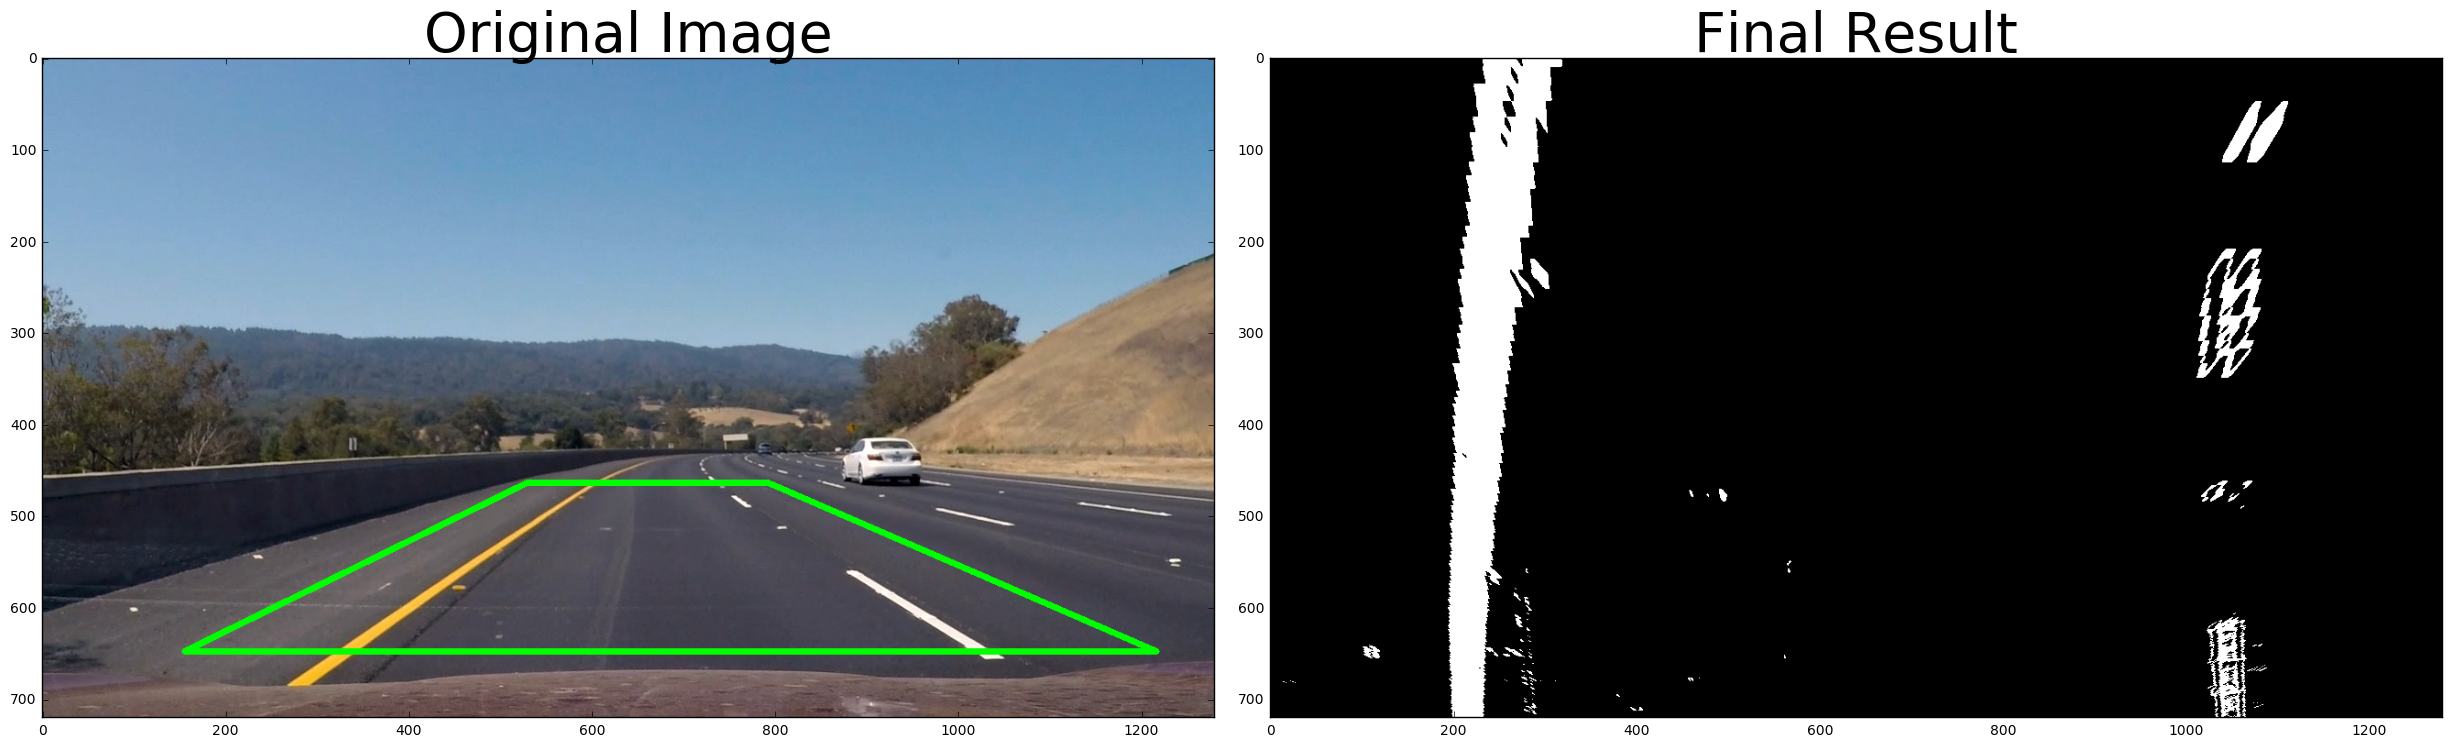

In [217]:
img = mpimg.imread("test_images/test3.jpg")
global attempted
attempted = False
cng = color_n_gradient(img)
src = process_image(img)
binary_warped,Minv = get_warped(cng,src)
lf,rf = line_detect(binary_warped)
print(lf[2]-rf[2])
# cng = color_n_gradient(img)
# src = process_image(img)
idx=[0,1,3,2]
img = cv2.polylines(img,[src[idx].reshape((-1,1,2))],True,(0,255,0),6)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(binary_warped,cmap="gray")
ax2.set_title('Final Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
def cal_curve_pixel():
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    print(left_curverad, right_curverad)

In [251]:
def cal_curve_real(left_fit,right_fit,binary_warped):
    # Define conversions in x and y from pixels space to meters
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return(left_curverad,right_curverad)
    # Example values: 632.1 m    626.2 m